In [1]:
%reset -sf

In [4]:
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
from opt_einsum import contract
from tqdm.auto import tqdm

def _toN(t):
    if isinstance(t,list):
        return np.array([_toN(x) for x in t])
    else:
        return np.array(t.detach().cpu()) if isinstance(t,torch.Tensor) else np.array(t)
        
def _toT(t):
    return torch.tensor(t) if not isinstance(t,torch.Tensor) else t
torch.cuda.set_device(1)
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

In [5]:
def Ising_T0(beta,h):
    beta,h=_toT(beta),_toT(h)
    a=torch.sqrt(torch.cosh(beta))
    b=torch.sqrt(torch.sinh(beta))
    c=torch.exp(beta*h)
    w=torch.stack([torch.stack([a,a]),torch.stack([b,-b])])
    z=torch.stack([c,1/c])
    return contract('iA,jA,kA,lA,A->ijkl',w,w,w,w,z)#UDLR

def Ising_SZT0(beta,h):
    beta,h=_toT(beta),_toT(h)
    a=torch.sqrt(torch.cosh(beta))
    b=torch.sqrt(torch.sinh(beta))
    c=torch.exp(beta*h)
    w=torch.stack([torch.stack([a,a]),torch.stack([b,-b])])
    z=torch.stack([c,-1/c])
    return contract('iA,jA,kA,lA,A->ijkl',w,w,w,w,z)#UDLR

R=_toT(np.diag([1.,-1.]))
T=Ising_T0(1.,0.)
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R,R,R)-T))
T=Ising_SZT0(1.,0.)
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R,R,R)+T))

def Ising3D_T0(beta,h):
    beta,h=_toT(beta),_toT(h)
    a=torch.sqrt(torch.cosh(beta))
    b=torch.sqrt(torch.sinh(beta))
    c=torch.exp(beta*h)
    w=torch.stack([torch.stack([a,a]),torch.stack([b,-b])])
    z=torch.stack([c,1/c])
    return contract('iA,jA,kA,lA,mA,nA,A->ijklmn',w,w,w,w,w,w,z)#UDLRFB

def Ising3D_SZT0(beta,h):
    beta,h=_toT(beta),_toT(h)
    a=torch.sqrt(torch.cosh(beta))
    b=torch.sqrt(torch.sinh(beta))
    c=torch.exp(beta*h)
    w=torch.stack([torch.stack([a,a]),torch.stack([b,-b])])
    z=torch.stack([c,-1/c])
    return contract('iA,jA,kA,lA,mA,nA,A->ijklmn',w,w,w,w,w,w,z)#UDLRFB

R=torch.tensor(np.diag([1.,-1.]))
T=Ising3D_T0(1.,0.)
print(torch.norm(contract('abcdef,aA,bB,cC,dD,eE,fF->ABCDEF',T,R,R.conj(),R,R.conj(),R,R.conj())-T))
T=Ising3D_SZT0(1.,0.)
print(torch.norm(contract('abcdef,aA,bB,cC,dD,eE,fF->ABCDEF',T,R,R.conj(),R,R.conj(),R,R.conj())+T))

tensor(8.1351e-16)
tensor(4.6903e-16)
tensor(6.7303e-16)
tensor(1.4678e-15)


In [6]:
def RepMat(dimV1R1,dimV1R2,dimV2R1,dimV2R2):
    dimV1=dimV1R1+dimV1R2
    dimV2=dimV2R1+dimV2R2
    P=torch.zeros([dimV1*dimV2,dimV1,dimV2])
    counter=0
    for i in range(dimV1R1):
        for j in range(dimV2R1):
            P[counter,i,j]=1
            counter+=1
    for i in range(dimV1R2):
        for j in range(dimV2R2):
            P[counter,dimV1R1+i,dimV2R1+j]=1
            counter+=1
    dimR1=counter
    for i in range(dimV1R1):
        for j in range(dimV2R2):
            P[counter,i,dimV2R1+j]=1
            counter+=1
    for i in range(dimV1R2):
        for j in range(dimV2R1):
            P[counter,dimV1R1+i,j]=1
            counter+=1
    dimR2=counter-dimR1
    P=P.reshape(dimV1*dimV2,-1)
    return P,dimR1,dimR2

In [7]:
def HOTRG_get_w(MM,dimRn1,dimRn2,max_dim):
    MM1,MM2=MM[:dimRn1,:dimRn1],MM[dimRn1:,dimRn1:]
    S1,U1=torch.linalg.eigh(MM1)#ascending, U S Uh=MM
    S2,U2=torch.linalg.eigh(MM2)
    S,U=[S1,S2],[U1,U2]
    max_dim=min(max_dim,dimRn1+dimRn2)
    chosenEigens=sorted([(-s,0,i) for i,s in enumerate(S1)]+[(-s,1,i) for i,s in enumerate(S2)])[:max_dim]
    chosenEigens.sort(key=lambda x:x[1])
    
    shift=[0,dimRn1]
    dim=[dimRn1,dimRn2]
    dimRnn=[0,0]
    w=torch.zeros((max_dim,dimRn1+dimRn2))
    for i,(s,rep,col) in enumerate(chosenEigens):
        w[i,shift[rep]:shift[rep]+dim[rep]]=U[rep][:,col]
        dimRnn[rep]+=1
    return w,dimRnn[0],dimRnn[1]

def HOTRG(T,dimR1,dimR2,max_dim):
    P,dimRn1,dimRn2=RepMat(dimR1,dimR2,dimR1,dimR2)
    #print(dimR1,dimR2,dimRn1,dimRn2)
    MM=contract('ijkl,jmno,ipql,pmro->knqr',T,T,T.conj(),T.conj()).reshape((dimRn1+dimRn2,dimRn1+dimRn2))
    MM=P@MM@P.T.conj()
    w,dimRnn1,dimRnn2=HOTRG_get_w(MM,dimRn1,dimRn2,max_dim)
    #display(MM,w@MM@w.T.conj())
    w=(w@P).reshape(-1,dimR1+dimR2,dimR1+dimR2)
    
    Tn=contract('ijkl,jmno,akn,blo->abim',T,T,w,w.conj())
    
    #print([dimR1,dimR2],dimRnn)
    return Tn,w,dimRnn1,dimRnn2

def HOTRG3D(T,dimR11,dimR12,dimR21,dimR22,max_dim):
    P1,dimRn11,dimRn12=RepMat(dimR11,dimR12,dimR11,dimR12)
    MM1=contract('ijklmn,jopqrs,itulmn,tovqrs->kpuv',T,T,T.conj(),T.conj()).reshape((dimRn11+dimRn12,dimRn11+dimRn12))
    MM1=P1@MM1@P1.T.conj()
    w1,dimRnn11,dimRnn12=HOTRG_get_w(MM1,dimRn11,dimRn12,max_dim)
    #display(MM,w@MM@w.T.conj())
    w1=(w1@P1).reshape(-1,dimR11+dimR12,dimR11+dimR12)
    
    P2,dimRn21,dimRn22=RepMat(dimR21,dimR22,dimR21,dimR22)
    MM2=contract('ijklmn,jopqrs,itklun,topqvs->mruv',T,T,T.conj(),T.conj()).reshape((dimRn21+dimRn22,dimRn21+dimRn22))
    MM2=P2@MM2@P2.T.conj()
    w2,dimRnn21,dimRnn22=HOTRG_get_w(MM2,dimRn21,dimRn22,max_dim)
    #display(MM,w@MM@w.T.conj())
    w2=(w2@P2).reshape(-1,dimR21+dimR22,dimR21+dimR22)
    
    #print(T.shape,w1.shape,w2.shape)
    Tn=contract('ijklmn,jopqrs,akp,blq,cmr,dns->abcdio',T,T,w1,w1.conj(),w2,w2.conj())
    
    #print([dimR1,dimR2],dimRnn)
    return Tn,w1,w2,dimRnn11,dimRnn12,dimRnn21,dimRnn22

In [8]:
def calc_isometries_HOTRG(T,dimR,max_dim,nLayers):
    #dimR[dir][rep]
    ws=[]
    logTotal=0
    logZ=[]
    for layer in range(nLayers):
        T,w,dimRn1,dimRn2=HOTRG(T,dimR[1][0],dimR[1][1],max_dim)
        dimR=[[dimRn1,dimRn2],dimR[0]]
        ws.append({'isometry':w,'multipilicity':[dimRn1,dimRn2]})
        norm=torch.linalg.norm(T)
        T=T/norm
        logTotal=2*logTotal+torch.log(norm)
        logZ.append((logTotal+torch.log(contract('aabb',T)))/2.**(layer+1))
    return T,logTotal,ws,logZ

def calc_isometries_HOTRG3D(T,dimR,max_dim,nLayers):
    #dimR[dir][rep]
    ws=[]
    logTotal=0
    logZ=[]
    for layer in tqdm(range(nLayers), leave=False):
        #print(dimR)
        T,w1,w2,dimRn11,dimRn12,dimRn21,dimRn22=HOTRG3D(T,dimR[1][0],dimR[1][1],dimR[2][0],dimR[2][1],max_dim)
        dimR=[[dimRn11,dimRn12],[dimRn21,dimRn22],dimR[0]]
        ws.append({'isometry':[w1,w2],'multipilicity':[[dimRn11,dimRn12],[dimRn21,dimRn22]]})
        norm=torch.linalg.norm(T)
        T=T/norm
        logTotal=2*logTotal+torch.log(norm)
        logZ.append((logTotal+torch.log(contract('aabbcc',T)))/2.**(layer+1))
    return T,logTotal,ws,logZ

T0,T0_op=Ising3D_T0(1.,0.),Ising3D_SZT0(1.,0.)
T,logTotal,ws,logZ=calc_isometries_HOTRG3D(T0,[[1,1]]*3,max_dim=4,nLayers=15)
print(_toN(logZ))

  0%|          | 0/15 [00:00<?, ?it/s]

[3.35564855 3.1734052  3.08664967 3.04332785 3.021667   3.01083657
 3.00542136 3.00271376 3.00135995 3.00068305 3.0003446  3.00017537
 3.00009076 3.00004846 3.0000273 ]


In [9]:
def evolve_tensor(T,T_op,ws,average=False,checkboard=False):
    logTotal=0
    M,M2=[],[]
    for layer in range(len(ws)):
        w=ws[layer]['isometry']
        T1=contract('ijkl,jmno,akn,blo->abim',T,T,w,w.conj())
        T2=contract('ijkl,jmno,akn,blo->abim',T_op,T,w,w.conj())
        if average:
            T3=contract('ijkl,jmno,akn,blo->abim',T,T_op,w,w.conj())
            if checkboard and layer<2:
                T3=-T3
            T2=(T2+T3)/2
        norm=torch.linalg.norm(T1)
        T,T_op=T1/norm,T2/norm
        logTotal=2*logTotal+torch.log(norm)
        
        M.append(contract('aabb',T_op)/contract('aabb',T))
        M2.append(contract('abcc,badd',T_op,T_op)/contract('abcc,badd',T,T))
    return T,T_op,logTotal,M,M2

def evolve_tensor3D(T,T_op,ws,average=False,checkboard=False):
    logTotal=0
    M,M2=[],[]
    for layer in tqdm(range(len(ws)), leave=False):
        w1,w2=ws[layer]['isometry']
        T1=contract('ijklmn,jopqrs,akp,blq,cmr,dns->abcdio',T,T,   w1,w1.conj(),w2,w2.conj())
        T2=contract('ijklmn,jopqrs,akp,blq,cmr,dns->abcdio',T,T_op,w1,w1.conj(),w2,w2.conj())
        if average:
            T3=contract('ijklmn,jopqrs,akp,blq,cmr,dns->abcdio',T_op,T,w1,w1.conj(),w2,w2.conj())
            if checkboard and layer<3:
                T3=-T3
            T2=(T2+T3)/2
        norm=torch.linalg.norm(T1)
        T,T_op=T1/norm,T2/norm
        logTotal=2*logTotal+torch.log(norm)
        
        M.append(contract('aabbcc',T_op)/contract('aabbcc',T))
        M2.append(contract('abccdd,baeeff',T_op,T_op)/contract('abccdd,baeeff',T,T))
    return T,T_op,logTotal,M,M2

T,T_op,logTotal,M,M2=evolve_tensor3D(T0,T0_op,ws)
print(_toN(M))
print(_toN(M2))

  0%|          | 0/15 [00:00<?, ?it/s]

[-1.78287057e-17 -2.24484021e-17 -3.93904425e-17 -7.18286818e-17
 -1.36702555e-16 -2.66449149e-16 -5.25942079e-16 -1.04492794e-15
 -2.08289966e-15 -4.15884310e-15 -8.31072997e-15 -1.66145037e-14
 -3.32220512e-14 -6.64371462e-14 -1.32867336e-13]
[0.99799104 0.99997414 0.99997506 0.99997536 0.99997536 0.99997536
 0.99997536 0.99997536 0.99997536 0.99997536 0.99997536 0.99997536
 0.99997536 0.99997536 0.99997536]


In [12]:
import pandas as pd
from tqdm.auto import tqdm

max_dim=2
nLayers=30

curve=pd.DataFrame()
for beta in tqdm(np.linspace(.2,.6,31)):
    with torch.no_grad():
        T0,T0_op=Ising_T0(beta,0),Ising_SZT0(beta,0)
        dimR=[[1,1]]*3
        T,logTotal,ws,logZ=calc_isometries_HOTRG(T0,dimR,max_dim=max_dim,nLayers=nLayers)
        T,T_op,logTotal,M,M2=evolve_tensor(T0,T0_op,ws,average=False)
        T,T_op,logTotal,M_average,M2_average=evolve_tensor(T0,T0_op,ws,average=True)
        
        newRow={'beta':beta,'logZ':logZ[-1],'M':M[-1],'sqrtM2':torch.sqrt(M2[-1]),'M_average':M_average[-1],'sqrtM2_average':torch.sqrt(M2_average[-1])}
        newRow={k:_toN(v) for k,v in newRow.items()}
        curve=curve.append(newRow,ignore_index=True)
    


  0%|          | 0/31 [00:00<?, ?it/s]

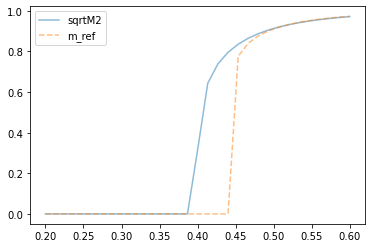

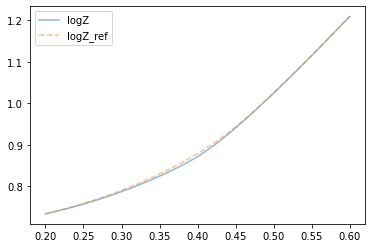

In [14]:
from IsingSolutions import Ising2DExactSolution
ising2DExactSolution=Ising2DExactSolution()

curve['logZ_ref']=ising2DExactSolution.logZ(curve['beta'])
curve['m_ref']=ising2DExactSolution.magnetization(curve['beta'])

import matplotlib.pyplot as plt
ls=['-','--','-.',':','.']*100
for i,label in enumerate(['sqrtM2','m_ref']):
    plt.plot(curve['beta'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.legend()
plt.show()
for i,label in enumerate(['logZ','logZ_ref']):
    plt.plot(curve['beta'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.legend()
plt.show()

In [11]:
import pandas as pd
from tqdm.auto import tqdm

max_dim=5
nLayers=30

curve=pd.DataFrame()
for beta in tqdm(np.linspace(.2,.3,31)):
    with torch.no_grad():
        T0,T0_op=Ising3D_T0(beta,0),Ising3D_SZT0(beta,0)
        dimR=[[1,1]]*3
        T,logTotal,ws,logZ=calc_isometries_HOTRG3D(T0,dimR,max_dim=max_dim,nLayers=nLayers)
        T,T_op,logTotal,M,M2=evolve_tensor3D(T0,T0_op,ws,average=False)
        T,T_op,logTotal,M_average,M2_average=evolve_tensor3D(T0,T0_op,ws,average=True)

        newRow={'beta':beta,'logZ':logZ[-1],'M':M[-1],'sqrtM2':torch.sqrt(M2[-1]),'M_average':M_average[-1],'sqrtM2_average':torch.sqrt(M2_average[-1])}
        newRow={k:_toN(v) for k,v in newRow.items()}
        curve=curve.append(newRow,ignore_index=True)
    


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

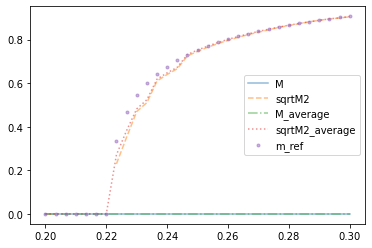

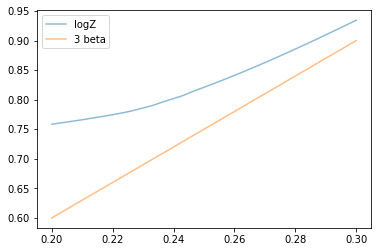

In [14]:
from IsingSolutions import Ising3DMonteCarlo
ising3DMonteCarlo=Ising3DMonteCarlo()

curve['m_ref']=ising3DMonteCarlo.magnetization(curve['beta'])

import matplotlib.pyplot as plt
ls=['-','--','-.',':','.']*100
for i,label in enumerate(['M','sqrtM2','M_average','sqrtM2_average','m_ref']):
    plt.plot(curve['beta'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.legend()
plt.show()

for i,label in enumerate(['logZ']):
    plt.plot(curve['beta'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.plot(curve['beta'],3*curve['beta'],ls[0],label='3 beta',alpha=.5)
plt.legend()
plt.show()

In [15]:
import pandas as pd
from tqdm.auto import tqdm

max_dim=5
nLayers=30

curve=pd.DataFrame()
for beta in tqdm(np.linspace(1,2,11)):
    with torch.no_grad():
        T0,T0_op=Ising3D_T0(beta,0),Ising3D_SZT0(beta,0)
        dimR=[[1,1]]*3
        T,logTotal,ws,logZ=calc_isometries_HOTRG3D(T0,dimR,max_dim=max_dim,nLayers=nLayers)
        T,T_op,logTotal,M,M2=evolve_tensor3D(T0,T0_op,ws,average=False)
        T,T_op,logTotal,M_average,M2_average=evolve_tensor3D(T0,T0_op,ws,average=True)

        newRow={'beta':beta,'logZ':logZ[-1],'M':M[-1],'sqrtM2':torch.sqrt(M2[-1]),'M_average':M_average[-1],'sqrtM2_average':torch.sqrt(M2_average[-1])}
        newRow={k:_toN(v) for k,v in newRow.items()}
        curve=curve.append(newRow,ignore_index=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

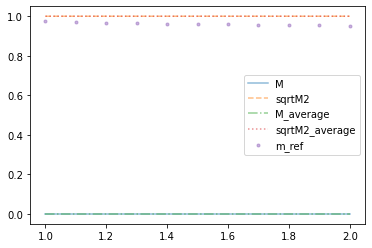

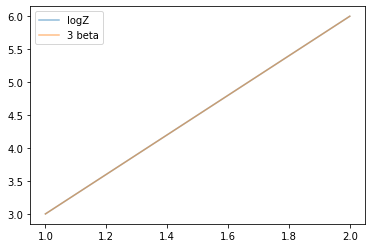

In [16]:
from IsingSolutions import Ising3DMonteCarlo
ising3DMonteCarlo=Ising3DMonteCarlo()

curve['m_ref']=ising3DMonteCarlo.magnetization(curve['beta'])

import matplotlib.pyplot as plt
ls=['-','--','-.',':','.']*100
for i,label in enumerate(['M','sqrtM2','M_average','sqrtM2_average','m_ref']):
    plt.plot(curve['beta'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.legend()
plt.show()

for i,label in enumerate(['logZ']):
    plt.plot(curve['beta'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.plot(curve['beta'],3*curve['beta'],ls[0],label='3 beta',alpha=.5)
plt.legend()
plt.show()

# AKLT3D

In [8]:
from scipy.special import comb
def get_CG_no_normalization(j):
    n=int(2*j)
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1
    return CG
def get_Lxyz(j):
    n=int(2*j+1)
    Lz=np.zeros((n,n))
    for i in range(n):
        m=i-j
        Lz[i,i]=m
    Lp=np.zeros((n,n))
    for i in range(n-1):
        m=i-j
        Lp[i+1,i]=np.sqrt(j*(j+1)-m*(m+1))
    Lm=Lp.T
    Lx=(Lp+Lm)/2
    iLy=(Lp-Lm)/2
    return Lx,iLy,Lz

AKLT_default_params={'a1':np.sqrt(6)/2,'a2':np.sqrt(6)}
def AKLT_T0(a1,a2):
    projector=torch.tensor(get_CG_no_normalization(2))
    singlet=torch.tensor([[0.,-1.],[1.,0.]])
    a0,a1,a2=_toT(1),_toT(a1),_toT(a2)
    deform=torch.stack([a2,a1,a0,a1,a2])
    node=contract('aijkl,io,kp,a->aojpl',projector,singlet,singlet,deform)
    T=contract('aijkl,aopqr->iojpkqlr',node,node).reshape(4,4,4,4)#UDLR
    r=torch.tensor([[1.,0.,0.,0.],[0.,0.,0.,1.],[0.,np.sqrt(.5),np.sqrt(.5),0.],[0.,np.sqrt(.5),-np.sqrt(.5),0.]])
    T=contract('ijkl,Ii,Jj,Kk,Ll->IJKL',T,r,r.conj(),r,r.conj())
    return T

def AKLT_ST0(a1,a2,axis):
    projector=torch.tensor(get_CG_no_normalization(2))
    singlet=torch.tensor([[0.,-1.],[1.,0.]])
    a0,a1,a2=_toT(1),_toT(a1),_toT(a2)
    deform=torch.stack([a2,a1,a0,a1,a2])
    node=contract('aijkl,io,kp,a->aojpl',projector,singlet,singlet,deform)
    op=torch.tensor(get_Lxyz(2)[axis])
    T=contract('aijkl,bopqr,ab->iojpkqlr',node,node,op).reshape(4,4,4,4)#UDLRFB
    r=torch.tensor([[1.,0.,0.,0.],[0.,0.,0.,1.],[0.,np.sqrt(.5),np.sqrt(.5),0.],[0.,np.sqrt(.5),-np.sqrt(.5),0.]])
    T=contract('ijkl,Ii,Jj,Kk,Ll->IJKL',T,r,r.conj(),r,r.conj())
    return T

T=AKLT_T0(1.,2.)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R.conj(),R,R.conj())-T))

T=AKLT_ST0(1.,2.,0)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R.conj(),R,R.conj())-T))

T=AKLT_ST0(1.,2.,1)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R.conj(),R,R.conj())+T))

T=AKLT_ST0(1.,2.,2)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R.conj(),R,R.conj())-T))

AKLT3D_default_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}
def AKLT3D_T0(a1,a2,a3):
    projector=torch.tensor(get_CG_no_normalization(3))
    singlet=torch.tensor([[0.,-1.],[1.,0.]])
    a0,a1,a2,a3=_toT(1),_toT(a1),_toT(a2),_toT(a3)
    deform=torch.stack([a3,a2,a1,a0,a1,a2,a3])
    node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
    T=contract('aijklmn,aopqrst->iojpkqlrmsnt',node,node).reshape(4,4,4,4,4,4)#UDLRFB
    r=torch.tensor([[1.,0.,0.,0.],[0.,0.,0.,1.],[0.,np.sqrt(.5),np.sqrt(.5),0.],[0.,np.sqrt(.5),-np.sqrt(.5),0.]])
    T=contract('ijklmn,Ii,Jj,Kk,Ll,Mm,Nn->IJKLMN',T,r,r.conj(),r,r.conj(),r,r.conj())
    return T

def AKLT3D_ST0(a1,a2,a3,axis):
    projector=torch.tensor(get_CG_no_normalization(3))
    singlet=torch.tensor([[0.,-1.],[1.,0.]])
    a0,a1,a2,a3=_toT(1),_toT(a1),_toT(a2),_toT(a3)
    deform=torch.stack([a3,a2,a1,a0,a1,a2,a3])
    node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
    op=torch.tensor(get_Lxyz(3)[axis])
    T=contract('aijklmn,bopqrst,ab->iojpkqlrmsnt',node,node,op).reshape(4,4,4,4,4,4)#UDLRFB
    r=torch.tensor([[1.,0.,0.,0.],[0.,0.,0.,1.],[0.,np.sqrt(.5),np.sqrt(.5),0.],[0.,np.sqrt(.5),-np.sqrt(.5),0.]])
    T=contract('ijklmn,Ii,Jj,Kk,Ll,Mm,Nn->IJKLMN',T,r,r.conj(),r,r.conj(),r,r.conj())
    return T

T=AKLT3D_T0(1.,2.,3.)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcdef,aA,bB,cC,dD,eE,fF->ABCDEF',T,R,R.conj(),R,R.conj(),R,R.conj())-T))

T=AKLT3D_ST0(1.,2.,3.,0)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcdef,aA,bB,cC,dD,eE,fF->ABCDEF',T,R,R.conj(),R,R.conj(),R,R.conj())-T))

T=AKLT3D_ST0(1.,2.,3.,1)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcdef,aA,bB,cC,dD,eE,fF->ABCDEF',T,R,R.conj(),R,R.conj(),R,R.conj())+T))

T=AKLT3D_ST0(1.,2.,3.,2)
R=torch.tensor(np.diag([1.,1.,1.,-1.]))
print(torch.norm(contract('abcdef,aA,bB,cC,dD,eE,fF->ABCDEF',T,R,R.conj(),R,R.conj(),R,R.conj())-T))

tensor(6.7707e-16)
tensor(9.8733e-16)
tensor(9.8733e-16)
tensor(4.1802e-16)
tensor(4.0499e-15)
tensor(8.9506e-15)
tensor(8.9506e-15)
tensor(5.7068e-15)


In [9]:
AKLT_default_params

{'a1': 1.224744871391589, 'a2': 2.449489742783178}

In [306]:
import pandas as pd
from tqdm.auto import tqdm

max_dim=4
nLayers=60

curve=pd.DataFrame()
a1=AKLT_default_params['a1']
for a2 in tqdm(np.linspace(2,4,21)):
    with torch.no_grad():
        T0=AKLT_T0(a1,a2)
        dimR=[[3,1]]*2
        T,logTotal,ws,logZ=calc_isometries_HOTRG(T0,dimR,max_dim=max_dim,nLayers=nLayers)
        newRow={'a1':a1,'a2':a2,'logZ':logZ[-1]}
        
        for axis,axisName in enumerate(['X','Y','Z']):
            T0_op=AKLT_ST0(a1,a2,axis)
            T,T_op,logTotal,M,M2=evolve_tensor(T0,T0_op,ws,checkboard=True,average=False)
            T,T_op,logTotal,M_average,M2_average=evolve_tensor(T0,T0_op,ws,checkboard=True,average=True)
            
            newRow[f'M{axisName}']=M[-1]
            newRow[f'sqrtM2{axisName}']=torch.sqrt(M2[-1])
            newRow[f'M{axisName}_average']=M_average[-1]
            newRow[f'sqrtM2{axisName}_average']=torch.sqrt(M2_average[-1])
        
        newRow={k:_toN(v) for k,v in newRow.items()}
        curve=curve.append(newRow,ignore_index=True)
    


  0%|          | 0/21 [00:00<?, ?it/s]

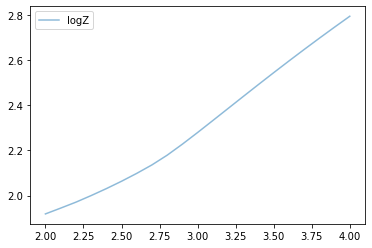

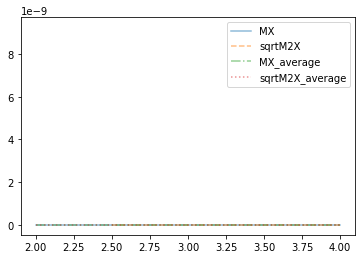

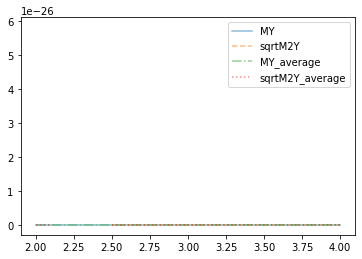

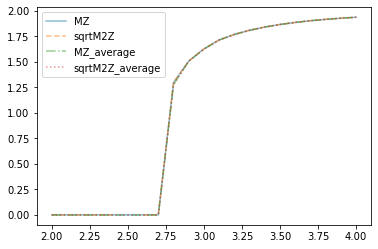

In [307]:
import matplotlib.pyplot as plt
ls=['-','--','-.',':','.']*100

for i,label in enumerate(['logZ']):
    plt.plot(curve['a2'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.legend()
plt.show()

for axis,axisName in enumerate(['X','Y','Z']):
    for i,label in enumerate([f'M{axisName}',f'sqrtM2{axisName}',f'M{axisName}_average',f'sqrtM2{axisName}_average']):
        plt.plot(curve['a2'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
    plt.legend()
    plt.show()


In [308]:
AKLT3D_default_params

{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 4.47213595499958}

In [10]:
import pandas as pd
from tqdm.auto import tqdm

max_dim=4
nLayers=30

curve=pd.DataFrame()
a1=AKLT3D_default_params['a1']
a2=AKLT3D_default_params['a2']
for a3 in tqdm(np.linspace(4,5,11)):
    with torch.no_grad():
        T0=AKLT3D_T0(a1,a2,a3)
        dimR=[[3,1]]*3
        T,logTotal,ws,logZ=calc_isometries_HOTRG3D(T0,dimR,max_dim=max_dim,nLayers=nLayers)
        newRow={'a1':a1,'a2':a2,'a3':a3,'logZ':logZ[-1]}
        
        for axis,axisName in enumerate(['X','Y','Z']):
            T0_op=AKLT3D_ST0(a1,a2,a3,axis)
            T,T_op,logTotal,M,M2=evolve_tensor3D(T0,T0_op,ws,checkboard=True,average=False)
            T,T_op,logTotal,M_average,M2_average=evolve_tensor3D(T0,T0_op,ws,checkboard=True,average=True)
            
            newRow[f'M{axisName}']=M[-1]
            newRow[f'sqrtM2{axisName}']=torch.sqrt(M2[-1])
            newRow[f'M{axisName}_average']=M_average[-1]
            newRow[f'sqrtM2{axisName}_average']=torch.sqrt(M2_average[-1])
        
        newRow={k:_toN(v) for k,v in newRow.items()}
        curve=curve.append(newRow,ignore_index=True)
    

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

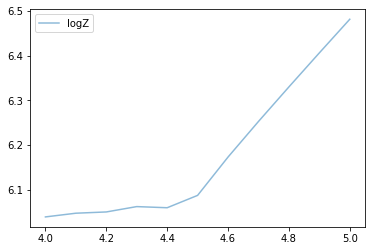

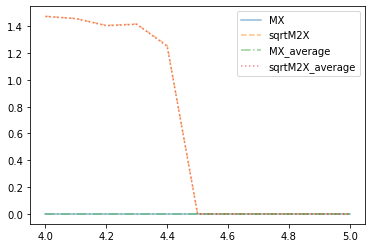

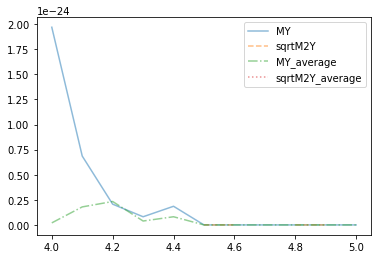

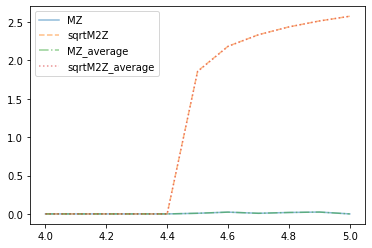

In [328]:
import matplotlib.pyplot as plt
ls=['-','--','-.',':','.']*100

for i,label in enumerate(['logZ']):
    plt.plot(curve['a3'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
plt.legend()
plt.show()

for axis,axisName in enumerate(['X','Y','Z']):
    for i,label in enumerate([f'M{axisName}',f'sqrtM2{axisName}',f'M{axisName}_average',f'sqrtM2{axisName}_average']):
        plt.plot(curve['a3'],np.abs(curve[label]),ls[i],label=label,alpha=.5)
    plt.legend()
    plt.show()
